John Eric Estrada <br>
2022 - 02217 <br>
CoE 197 Z <br>
ME 1 - OCR on Receipts <br>
microsoft/Florence-2-base <br>
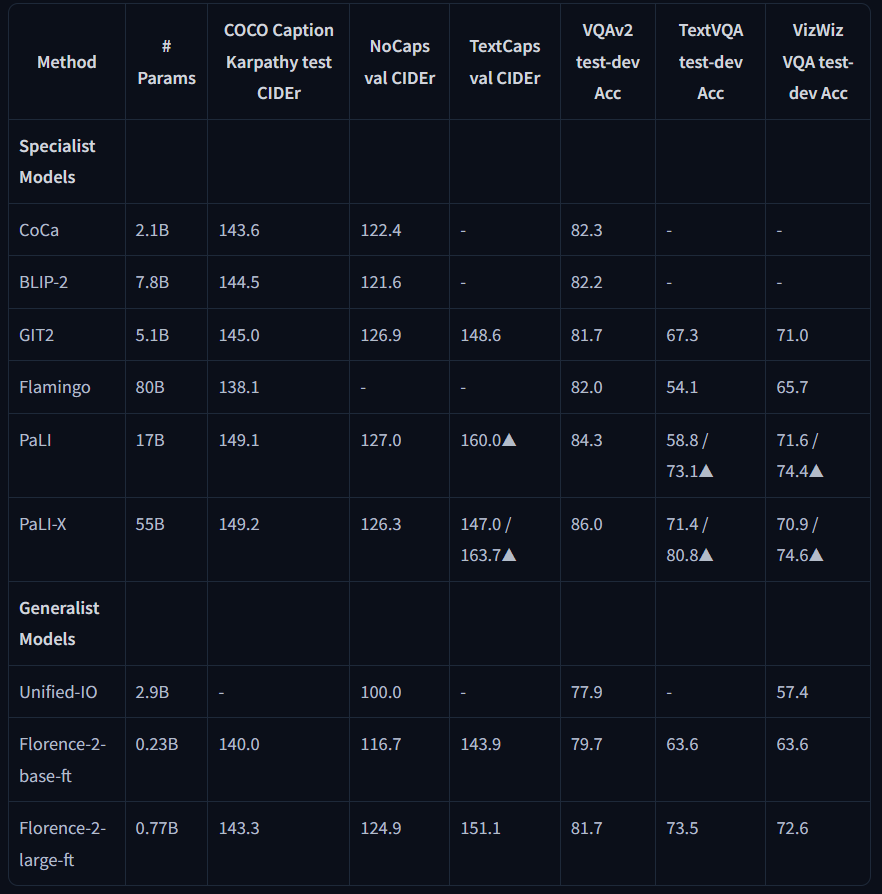 <br>
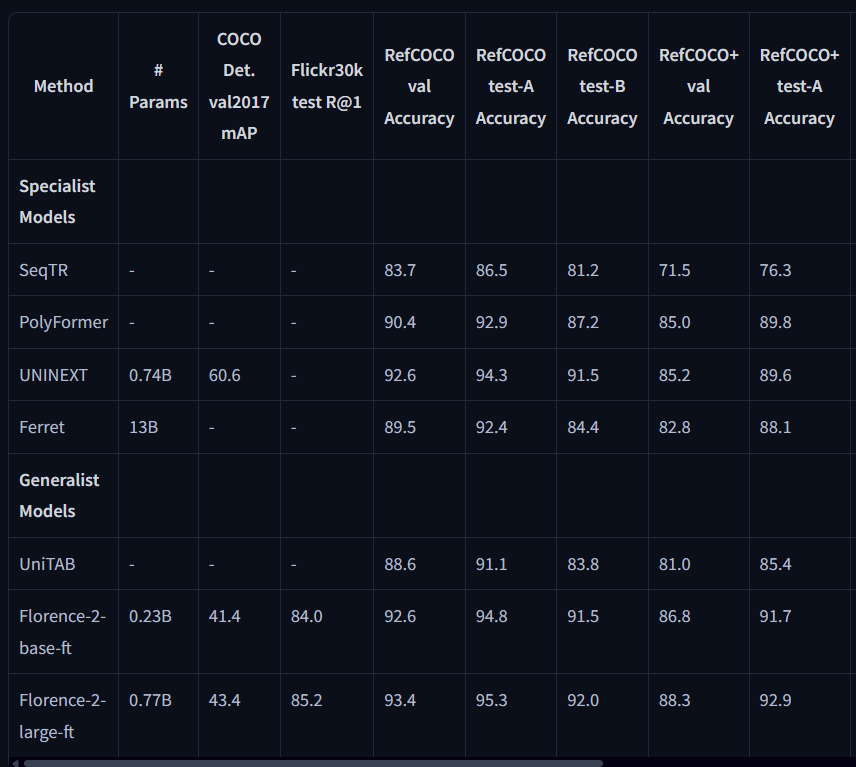

In [1]:
%pip install torch
%pip install gradio
%pip install transformers
%pip install Image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import gradio as gr
from PIL import ImageEnhance, ImageFilter
from transformers import AutoProcessor, AutoModelForCausalLM

import error: No module named 'triton'


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

c:\Users\User\Documents\coe197z\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [6]:
# Process image
def process_image(image):
    if image is None: # Just to check if an image is passed
        return("No image found")
    
    # Enhance the image for better OCR results
    image = image.filter(ImageFilter.SHARPEN)  # Sharpen the image
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2)  # Increase contrast
    
    prompt = "<OCR_WITH_REGION>"
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=4096,
        num_beams=3,
        do_sample=False
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task=prompt, image_size=(image.width, image.height))

    return '\n'.join(x.replace('</s>', '') for x in parsed_answer[prompt]['labels'])

# For styling the gradio app
css = """
#input_image, #output_text { 
    display: block !important;
    width: 100% !important;
}
"""

# Initialize Gradio interface
with gr.Blocks(css=css) as demo:
    gr.Markdown("# CoE 197 Z - Machine Exercise 1: OCR on Receipts")
    gr.Markdown("This is a OCR app using Gradio using the microsoft/Florence-2-base model <br> John Eric Estrada <br> SN 2022-02217")
    with gr.Column(elem_id="container"):
        with gr.Row(elem_id="input-container"):
            webcam_input = gr.Image(sources=["webcam", "upload"], type="pil", mirror_webcam=False)
        output_text = gr.Textbox(label="OCR Output")

        webcam_input.change(fn=process_image, inputs=webcam_input, outputs=output_text)


In [7]:
# Run it
if __name__ == "__main__":
    demo.launch(share = True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://4af8f042ed792617e8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
